In [11]:
import os
import torch
import torchvision
from torch.utils.data import random_split, Subset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
data_dir = '/content/drive/MyDrive/Dataset'

In [14]:

#Responsible for converting images (resizing and adding it to folder)
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])


# transformations = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Load the dataset from the root directory, applying the transformations



dataset = ImageFolder(data_dir, transform = transformations)

In [15]:
dataset.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: metal (Class No: 2)


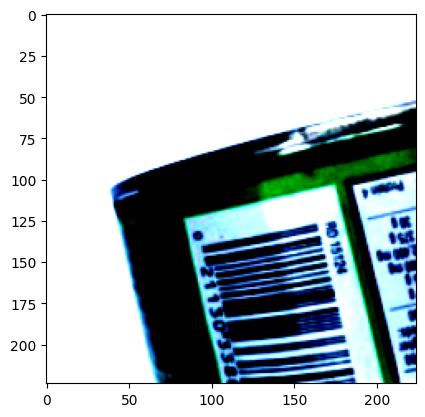

In [17]:
img, label = dataset[1000]
show_sample(img, label)


In [18]:
label

2

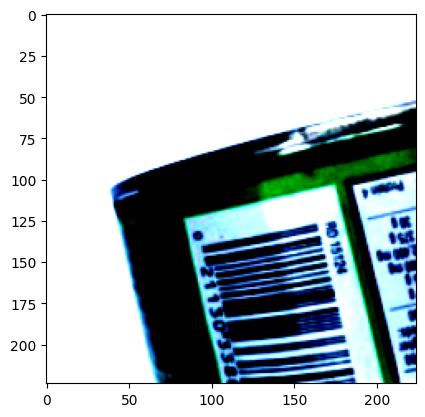

In [19]:
plt.imshow(img.permute(1, 2, 0))

In [20]:
labels = [label for _, label in dataset.samples]

In [21]:
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    list(range(len(labels))), labels, test_size=0.3, stratify=labels, random_state=42)

val_indices, test_indices, val_labels, test_labels = train_test_split(
    temp_indices, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Create subsets
train_ds = Subset(dataset, train_indices)
val_ds = Subset(dataset, val_indices)
test_ds = Subset(dataset, test_indices)

In [22]:
# random_seed = 42
# torch.manual_seed(random_seed)

In [23]:
# train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
# len(train_ds), len(val_ds), len(test_ds)

In [24]:

batch_size = 32

In [25]:
#Training and Vaidation part
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=False, num_workers  = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, shuffle=False, num_workers=4, pin_memory = True )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
       print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [28]:
class ResNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.network = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Updated weight loading
        for param in self.network.parameters():
            param.requires_grad = False
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return self.network(xb)

num_classes = len(dataset.classes)

model = ResNet(num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.1MB/s]


In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):

      """Number of batches"""
      return len(self.dl)


In [30]:
device = get_default_device()
device

device(type='cpu')

In [31]:
# train_dl = DeviceDataLoader(train_dl, device)
# val_dl = DeviceDataLoader(val_dl, device)
# to_device(model, device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = to_device(model, device)

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(filter(lambda p: p.requires_grad, model.parameters()), lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        scheduler.step()
    return history

In [33]:
# model = to_device(ResNet(), device)

In [ ]:
num_epochs = 15
lr = 1e-3
opt_func = torch.optim.SGD

# Train the model
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

# Unfreeze all layers for fine-tuning
for param in model.network.parameters():
    param.requires_grad = True

Epoch 1: train_loss: 1.4307, val_loss: 1.1232, val_acc: 0.6683
Epoch 2: train_loss: 1.0002, val_loss: 0.8876, val_acc: 0.7441
Epoch 3: train_loss: 0.8685, val_loss: 0.7754, val_acc: 0.7599
Epoch 4: train_loss: 0.7675, val_loss: 0.7497, val_acc: 0.7471


In [ ]:
num_epochs_finetune = 15
lr_finetune = 1e-4
history += fit(num_epochs_finetune, lr_finetune, model, train_dl, val_dl, opt_func)


In [ ]:
evaluate(model, val_dl)


In [ ]:

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model.h5')

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. Epochs')
    plt.show()

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Epochs')
    plt.show()

In [ ]:
plot_accuracies(history)
plot_losses(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))


In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://s7d1.scene7.com/is/image/mcdonalds/t-mcdonalds-Dasani-Water:1-3-product-tile-desktop?wid=765&hei=472&dpr=off", "dasani.jpg")

In [ ]:
from PIL import Image


def predict_external_image(image_name):
    image = Image.open(image_name).convert('RGB')
    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0).clamp(0, 1))
    plt.axis('off')
    plt.show()
    print("The image resembles", predict_image(example_image, model) + ".")

In [ ]:
predict_external_image('dasani.jpg')

In [ ]:
img, label = test_ds[24]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
predict_external_image('/content/drive/MyDrive/Colab Notebooks/metal.jpg')

In [ ]:
# To download web images
import urllib.request

In [ ]:
#Image 2 - Wine Bottle
urllib.request.urlretrieve("https://media.glamour.com/photos/585c2e2dd7d207db1cc80657/1:1/w_2000,h_2000,c_limit/Ca%E2%80%99Momi%20Rosso%20Dolce%202014%20.jpg", "winebottle.jpg")

In [ ]:
predict_external_image('winebottle.jpg')

In [ ]:
predict_external_image('/content/drive/MyDrive/Colab Notebooks/plastic80.jpg')

In [ ]:
predict_external_image('/content/drive/MyDrive/Colab Notebooks/metal203.jpg')

In [ ]:
#Image 9 - Dasani Waterbottle
urllib.request.urlretrieve("https://s7d1.scene7.com/is/image/mcdonalds/t-mcdonalds-Dasani-Water:1-3-product-tile-desktop?wid=765&hei=472&dpr=off", "dasani.jpg")

In [ ]:
predict_external_image('dasani.jpg')

In [ ]:
predict_external_image('/content/drive/MyDrive/Colab Notebooks/apniplastic.jpg')

In [ ]:
predict_external_image('/content/drive/MyDrive/Colab Notebooks/oreo.jpg')

In [ ]:
predict_external_image('/content/drive/MyDrive/Colab Notebooks/metal192.jpg')

In [ ]:
predict_external_image('/content/drive/MyDrive/Colab Notebooks/metal38.jpg')